In [1]:
import numpy as np
import numpy.polynomial.polynomial as P

import pandas as pd
import glob
import os
import math
import textwrap
from importlib import reload

from sklearn import metrics
from regress2 import regress2
from scipy import stats as sts
import statsmodels.api as sm

In [2]:
import geopandas
import cartopy.io.img_tiles as cimgt

import cartopy as cart
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
from cartopy import config
from shapely.geometry import Point
from shapely.prepared import prep
import cartopy

import shapely.geometry as sgeom
from scipy.io import netcdf

import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)
warnings.filterwarnings("ignore", module = "matplotlib\..*" )

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as mpatches
from matplotlib import colors as ccolors
from matplotlib.ticker import MaxNLocator

mycmap = matplotlib.cm.get_cmap('PiYG')

In [3]:
np.random.seed(9876789)

nsample = 100
x = np.linspace(0, 10, 100)
beta = np.array([1, 10])
e = np.random.normal(0, 10, size=nsample)
X = sm.add_constant(x)
y = np.dot(X, beta) + e
Y = sm.add_constant(y)

results1 = sm.OLS(y, X).fit()
results2 = sm.OLS(x, Y).fit()

pred1 = np.dot(X,results1.params)
pred2 = np.dot(Y,results2.params)

print("Parameters: ", results1.params, results2.params)
print("R2: ", results1.rsquared, results2.rsquared)

xpred1 = (y - results1.params[0])/results1.params[1]
xres = np.abs(x - xpred1)
yres = np.abs(y - pred1)
rdp = 0.5*xres*yres

foo = pd.DataFrame()
foo['xres'] = xres
foo['yres'] = yres
foo['rdp']  = rdp
foo.describe()

Parameters:  [2.73168469 9.62286251] [0.36538068 0.09115013]
R2:  0.8771251811753473 0.8771251811753473


,xres,yres,rdp
count,100.000000,100.000000,100.000000
mean,0.884011,8.506716,5.730342
std,0.643153,6.188974,7.300334
min,0.002200,0.021166,0.000023
25%,0.321505,3.093799,0.497357
50%,0.750216,7.219227,2.708069
75%,1.271832,12.238661,7.782765
max,2.885186,27.763751,40.051797


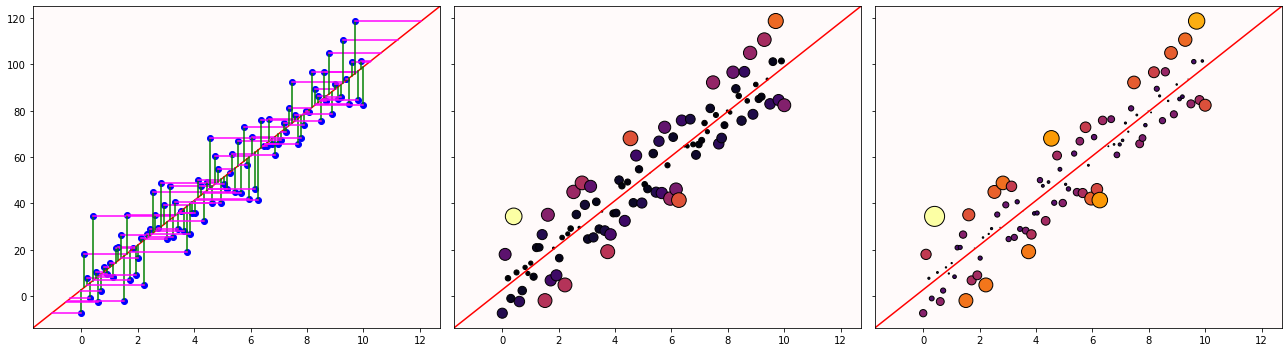

In [4]:
fig, ax = plt.subplots(1,3, figsize=(18,5), sharex=True, sharey=True)

ax[0].scatter(x,y, c='b')
ax[0].axline(xy1=(0,results1.params[0]), slope=results1.params[1], c='r')
for i in range(len(yres)):
    ax[0].plot([x[i], x[i]], [pred1[i], y[i]], c='green')
    ax[0].plot([xpred1[i], x[i]], [y[i], y[i]], c='magenta')

ax[1].axline(xy1=(0,results1.params[0]), slope=results1.params[1], c='r')
ax[1].scatter(x,y, c=rdp, cmap='inferno', edgecolor='k', s=yres*1e1)

ax[2].axline(xy1=(0,results1.params[0]), slope=results1.params[1], c='r')
ax[2].scatter(x,y, c=yres, cmap='inferno', edgecolor='k', s=rdp*1e1)

#ax[1].scatter(y,x, c='b')
#ax[1].axline(xy1=(0,results2.params[0]), slope=results2.params[1], c='r')
#ax[1].axline(xy1=(0,-results1.params[0]/results1.params[0]), slope=1/results1.params[1], c='k')

for i in range(len(ax)):
    ax[i].set_facecolor('snow')

fig.tight_layout()

In [5]:
filename = '../data/geonames_countryInfo.txt'
meta = pd.read_csv(filename, skiprows=49, usecols=[0,1,4,5,6,7,8,9], keep_default_na=False)
isos = pd.unique(meta['ISO'])

meta.head()

,ISO,ISO3,Country,Capital,Area(in sq km),Population,Continent,GlobalDesignation
0,AD,AND,Andorra,Andorra la Vella,468.0,77006,EU,GN
1,AE,ARE,United Arab Emirates,Abu Dhabi,82880.0,9630959,AS,GS
2,AF,AFG,Afghanistan,Kabul,647500.0,37172386,AS,GS
3,AG,ATG,Antigua and Barbuda,St. John's,443.0,96286,NA,GS
4,AI,AIA,Anguilla,The Valley,102.0,13254,NA,GS


In [6]:
filename = '../data/merged_research_cities500.csv'
data = pd.read_csv(filename, keep_default_na=False)
data = data[data['score'] > 0]
print(data.shape)
isos = pd.unique(data['country_code'])
#data.head()

(7129, 11)


In [7]:
north_mask = np.zeros(len(data), dtype=np.bool)
for i,c in enumerate(data['country_code']):
    if meta[meta['ISO'] == c]['GlobalDesignation'].values[0] == 'GN':
        north_mask[i] = True

In [8]:
data['global_north'] = north_mask
data.head()

,country_code,country,location,score,incountry_rank,matched_iso,matched_pop,dist_difference,population,latitude,longitude,global_north
0,AF,Afghanistan,"Kabul, Afghanistan",7,0,AF,Kabul,4.419195,4489112,34.555349,69.207486,False
1,AF,Afghanistan,"Kandahar, Afghanistan",3,1,AF,Kandahar,3.089936,523300,31.628871,65.737175,False
2,AF,Afghanistan,"Helmand, Afghanistan",2,2,AF,Markaz-e Hukumat-e Darweshan,34.057000,9012,31.363647,63.958611,False
3,AF,Afghanistan,"Herat, Afghanistan",1,3,AF,Herat,0.657768,586235,34.352865,62.204029,False
4,AF,Afghanistan,"Logar, Afghanistan",1,4,AF,Pul-e 'Alam,15.784375,35552,34.014552,69.192392,False


In [9]:
fs = 15
colors = ['blue', 'dimgray', 'red']
labels = ['Global North', 'All Globe', 'Global South']

rmask = (data.score > 0).values
nmask = north_mask & rmask
smask = ~north_mask & rmask

trait_x = np.log(data.loc[:, 'population'].values)
trait_y = np.log(data.loc[:, 'score'].values)
tinv = lambda p, df: abs(sts.t.ppf(p/2, df))

lrs_scores = [metrics.r2_score, 
              metrics.mean_absolute_error, 
              metrics.mean_squared_error, 
              metrics.mean_squared_log_error,
              metrics.median_absolute_error]
lrs_scores_tags = ['r2',
                   'mean_abs',
                   'mean_sqr',
                   'mean_sqr_log',
                   'median_abs']

In [11]:
## ORDINARY LEAST SQUARES

LRS = []

for i, mask in enumerate([nmask, rmask, smask]):
    lrs = dict()
    
    xx = trait_x[mask]
    yy = trait_y[mask]
    
    ols = sts.linregress(xx, yy)
    lrs['slope'] = ols.slope
    lrs['intercept'] = ols.intercept
    lrs['r'] = ols.rvalue
    lrs['std_slope'] = ols.stderr
    #lrs['std_intercept'] = ols.intercept_stderr
    
    lrs['predict'] = ols.intercept + ols.slope*xx
    
    ts = tinv(0.05, len(xx)-2)
    lrs['c95_slope'] = ts*lrs['std_slope']
    #lrs['c95_intercept'] = ts*lrs['std_intercept']
    
    for j in range(len(lrs_scores)):
        yt = lrs['predict'] - np.min(lrs['predict'])
        y0 = yy - np.min(lrs['predict'])
        lrs[lrs_scores_tags[j]] = lrs_scores[j](y0, yt)
    
    LRS.append(lrs)
    
for i in range(len(LRS)):
    bar = [LRS[i]['slope'], LRS[i]['intercept'], LRS[i]['c95_slope'], LRS[i]['r']]
    foo = '{:.02}\t'*len(bar)
    foo = foo.format(*bar)
    print(labels[i],foo, sep='\t')
    bar = [LRS[i][j] for j in lrs_scores_tags]
    foo = '{:.04}\t'*len(bar)
    foo = foo.format(*bar)
    print('\t',foo, sep='\t')

Global North	0.71	-5.6	0.031	0.59	
		0.3478	1.426	3.017	0.1405	1.258	
All Globe	0.64	-5.1	0.022	0.55	
		0.3041	1.376	2.866	0.1387	1.199	
Global South	0.65	-5.7	0.032	0.57	
		0.3295	1.242	2.333	0.1003	1.094	


In [10]:
## REDUCED MAJOR AXIS

LRS = []

for i, mask in enumerate([nmask, rmask, smask]):
    
    xx = trait_x[mask]
    yy = trait_y[mask]
    
    rma = regress2(xx, yy, _method_type_2="reduced major axis")
    
    #ts = tinv(0.05, len(xx)-2)
    #std_slope = ts*rma['std_slope']
    #std_inter = ts*rma['std_intercept']
    #rma['c95_slope'] = std_slope
    #rma['c95_inter'] = std_inter
        
    rma['xpredict'] = (yy - rma['intercept'])/rma['slope']
    xres = np.abs(xx - rma['xpredict'])
    yres = yy - rma['predict']
    rma['rdp'] = 0.5*xres*yres
    
    for j in range(len(lrs_scores)):
        yt = rma['predict'] - np.min(rma['predict'])
        y0 = yy - np.min(rma['predict'])
        rma[lrs_scores_tags[j]] = lrs_scores[j](y0, yt)
    
    LRS.append(rma)
    
for i in range(len(LRS)):
    bar = [LRS[i]['r'], LRS[i]['slope'], LRS[i]['intercept']]#, LRS[i]['c95_slope'], LRS[i]['c95_inter']]
    foo = '{:.02}\t'*len(bar)
    foo = foo.format(*bar)
    print(labels[i],foo, sep='\t')
    bar = [LRS[i][j] for j in lrs_scores_tags]
    foo = '{:.04}\t'*len(bar)
    foo = foo.format(*bar)
    print('\t',foo, sep='\t')

Global North	0.59	1.2	-1.1e+01	
		0.1795	1.568	3.796	0.09214	1.334	
All Globe	0.55	1.2	-1.1e+01	
		0.103	1.541	3.694	0.08308	1.325	
Global South	0.57	1.1	-1.1e+01	
		0.1484	1.373	2.963	0.06122	1.167	


In [120]:
## MAJOR AXIS

LRS = []

for i, mask in enumerate([nmask, rmask, smask]):
    
    xx = trait_x[mask]
    yy = trait_y[mask]
    
    rma = regress2(xx, yy, _method_type_2="major axis")
    
    ts = tinv(0.05, len(xx)-2)
    std_slope = ts*rma['std_slope']
    std_inter = ts*rma['std_intercept']
    
    rma['c95_slope'] = std_slope
    rma['c95_inter'] = std_inter

    for j in range(len(lrs_scores)):
        yt = rma['predict'] - np.min(rma['predict'])
        y0 = yy - np.min(rma['predict'])
        rma[lrs_scores_tags[j]] = lrs_scores[j](y0, yt)
    
    LRS.append(rma)
    
for i in range(len(LRS)):
    bar = [LRS[i]['slope'], LRS[i]['intercept'], LRS[i]['c95_slope'], LRS[i]['r']]
    foo = '{:.02}\t'*len(bar)
    foo = foo.format(*bar)
    print(labels[i],foo, sep='\t')
    bar = [LRS[i][j] for j in lrs_scores_tags]
    foo = '{:.04}\t'*len(bar)
    foo = foo.format(*bar)
    print('\t',foo, sep='\t')

Global North	1.4	-1.3e+01	0.06	0.59	
		0.04707	1.683	4.409	0.09161	1.425	
All Globe	1.3	-1.3e+01	0.045	0.55	
		-0.0202	1.636	4.201	0.08193	1.378	
Global South	1.2	-1.3e+01	0.06	0.57	
		0.05778	1.437	3.278	0.06001	1.21	


In [121]:
## THEIL-SEN ESTIMATOR

LRS = []

for i, mask in enumerate([nmask, rmask, smask]):
    lrs = dict()
    
    xx = trait_x[mask]
    yy = trait_y[mask]
    
    tse = sts.theilslopes(xx, yy)
    
    lrs['slope'] = tse[0]
    lrs['intercept'] = tse[1]
    lrs['r'] = sts.pearsonr(xx, yy)[0]
    
    #lrs['std_slope'] = ols.stderr
    #lrs['std_intercept'] = ols.intercept_stderr
    
    lrs['predict'] = tse[0] + tse[1]*xx
    
    ts = tinv(0.05, len(xx)-2)
    lrs['c95_slope'] = tse[3] - lrs['slope']
    lrs['c95_inter'] = np.median(yy) - tse[3]*np.median(xx)

    for j in range(len(lrs_scores)):
        yt = lrs['predict']# - np.min(lrs['predict'])
        y0 = yy# - np.min(lrs['predict'])
        lrs[lrs_scores_tags[j]] = lrs_scores[j](y0, yt)
    
    LRS.append(rma)
    
for i in range(len(LRS)):
    bar = [LRS[i]['slope'], LRS[i]['intercept'], LRS[i]['c95_slope'], LRS[i]['r']]
    foo = '{:.02}\t'*len(bar)
    foo = foo.format(*bar)
    print(labels[i],foo, sep='\t')
    bar = [LRS[i][j] for j in lrs_scores_tags]
    foo = '{:.04}\t'*len(bar)
    foo = foo.format(*bar)
    print('\t',foo, sep='\t')

Global North	1.2	-1.3e+01	0.06	0.57	
		0.05778	1.437	3.278	0.06001	1.21	
All Globe	1.2	-1.3e+01	0.06	0.57	
		0.05778	1.437	3.278	0.06001	1.21	
Global South	1.2	-1.3e+01	0.06	0.57	
		0.05778	1.437	3.278	0.06001	1.21	


../plots/global_population_allometry


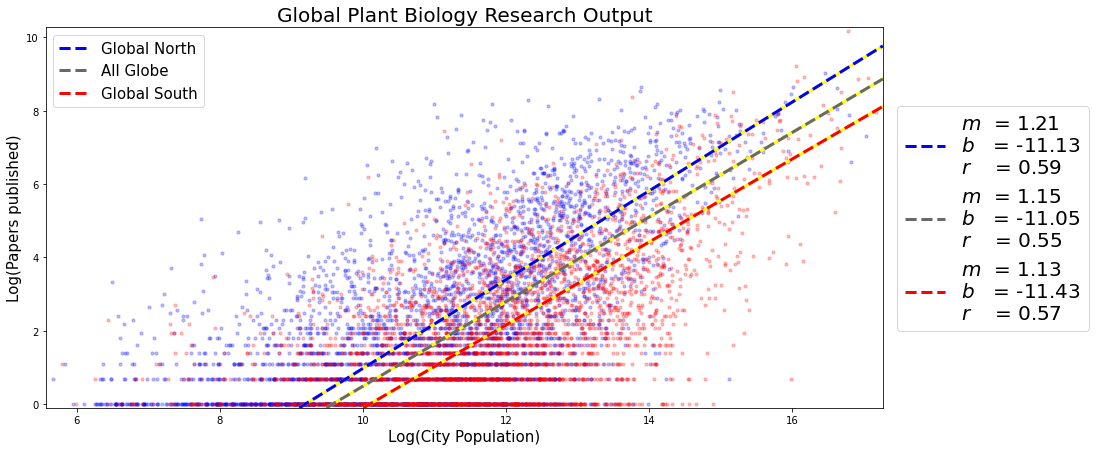

In [11]:
legends = ['', '', '']
fig, ax = plt.subplots(1,1, figsize=(15,7))

ax.set_xlim((np.min(trait_x[rmask])-0.1, np.max(trait_x)+0.1))
ax.set_ylim((np.min(trait_y[rmask])-0.1, np.max(trait_y)+0.1))

for i, mask in enumerate([nmask, rmask, smask]):
    
    xx = trait_x[mask]
    yy = trait_y[mask]

    legends[i] = '$m$  = {:.2f}\n$b$   = {:.2f}\n$r$    = {:.2f}'.format(LRS[i]['slope'], LRS[i]['intercept'], LRS[i]['r'])
    ax.axline(xy1=(0,LRS[i]['intercept']), slope=LRS[i]['slope'], color='yellow', lw=3, ls='-')
    ax.axline(xy1=(0,LRS[i]['intercept']), slope=LRS[i]['slope'], color=colors[i], label=labels[i], lw=3, ls='--')

for i, mask in ([(0,nmask),(2,smask)]):
    xx = trait_x[mask]
    yy = trait_y[mask]
    
    ax.scatter(xx,yy, c=colors[i], s=10, alpha=0.25)

ax.legend(fontsize=fs);

h, l = ax.get_legend_handles_labels()
fig.legend(h, legends, fontsize=20, loc='right', fancybox=True,
           bbox_to_anchor=(1.1, 0.5));

ax.set_xlabel('Log(City Population)', fontsize=fs)
ax.set_ylabel('Log(Papers published)', fontsize=fs)
ax.set_title('Global Plant Biology Research Output', fontsize=fs+5)

filename = '../plots/global_population_allometry'
print(filename)
plt.savefig(filename + '.jpg', dpi=100, format='jpg', bbox_inches='tight', pil_kwargs={'optimize':True})
#plt.savefig(filename + '.pdf', format='pdf', bbox_inches='tight')
#fig.set_alpha(0)
#plt.savefig(filename + '.svg', format='svg', transparent=False, facecolor=fig.get_facecolor(), bbox_inches='tight')

In [50]:
for i in range(len(LRS)):
    print(LRS[i]['slope']-LRS[0]['c95_slope'], LRS[i]['slope']+LRS[i]['c95_slope'])
    print(LRS[i]['intercept']-LRS[0]['c95_inter'], LRS[i]['intercept']+LRS[i]['c95_inter'])
    print()

1.1758825103878514 1.2454365266014034
-11.522121657092942 -10.740763212928659

1.1187325649112467 1.178878341351231
-11.43663569762679 -10.752210031637201

1.0974468311372245 1.1678762334267474
-11.818927026237446 -11.00162877319598



In [24]:
print(np.exp(LRS[0]['intercept'] - LRS[2]['intercept']))
print(np.exp(LRS[0]['intercept']-LRS[0]['c95_inter'] - (LRS[2]['intercept']+LRS[2]['c95_inter'])))
print(np.exp(LRS[0]['intercept']+LRS[0]['c95_inter'] - (LRS[2]['intercept']-LRS[2]['c95_inter'])))

1.345553387753902
0.5942275905686106
3.0468358387121337


In [26]:
print(LRS[0]['slope'] - LRS[2]['slope'])
print(LRS[0]['slope']-LRS[0]['c95_slope'] - (LRS[2]['slope']+LRS[2]['c95_slope']))
print(LRS[0]['slope']+LRS[0]['c95_slope'] - (LRS[2]['slope']-LRS[2]['c95_slope']))

0.07843567925062689
0.008006276961104009
0.14886508154014977


In [115]:
print(sum(data.global_north.values))
print(len(data) - sum(data.global_north.values))

3824
3305


In [116]:
## BOOTSTRAP
BT = int(1e5)
bootstrap = np.zeros((BT, len(LRS), 2))
tmask = np.ones(len(data), dtype = np.bool)
rng = np.random.default_rng(42)
    

for i in range(BT):
    bmask = rng.integers(0,len(data),len(data))
    bnmask = data.loc[bmask, 'global_north'].values
    bsmask = ~bnmask
    
    for j,mask in enumerate([bnmask, tmask, bsmask]):
    
        xx = trait_x[bmask][mask]
        yy = trait_y[bmask][mask]
    
        rma = regress2(xx, yy, _method_type_2="reduced major axis")
    
        bootstrap[i,j] = rma['slope'], rma['intercept']

In [198]:
filename = '../results/bootstrap_rma'
np.save(filename, bootstrap)

In [17]:
filename = '../results/bootstrap_rma.npy'
bootstrap = np.load(filename)
BT = len(bootstrap)

In [14]:
bq_slope = np.quantile(bootstrap[:,:,0], [0.025, 0.975], axis=0)
bq_inter = np.quantile(bootstrap[:,:,1], [0.025, 0.975], axis=0)

In [18]:
bgap = np.zeros((BT, 2))
for i in range(BT):
    delta_slope = bootstrap[i,0,0] - bootstrap[i,2,0]
    delta_inter = bootstrap[i,0,1] - bootstrap[i,2,1]
    bgap[i] = [delta_slope, delta_inter]

In [19]:
bqgap = np.quantile(bgap, [0.025, 0.5, 0.975], axis=0)
bqgap

array([[ 0.03439204, -0.22719353],
       [ 0.07839657,  0.2969932 ],
       [ 0.12266312,  0.81538409]])

../plots/global_population_allometry_bootstrapped


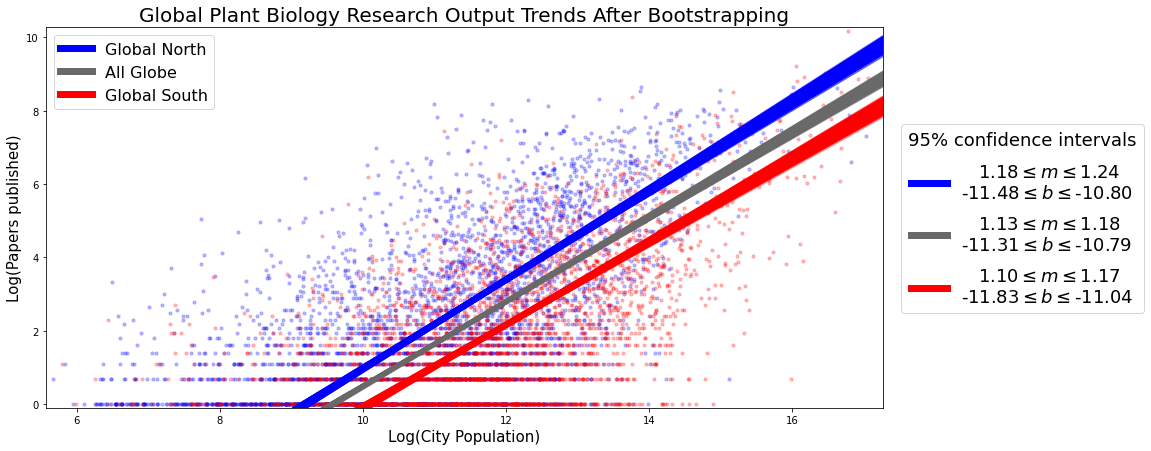

In [197]:
legends = ['', '', '']
fig, ax = plt.subplots(1,1, figsize=(15,7))

ax.set_xlim((np.min(trait_x[rmask])-0.1, np.max(trait_x)+0.1))
ax.set_ylim((np.min(trait_y[rmask])-0.1, np.max(trait_y)+0.1))

for i in range(0, BT, 100):
    for j in range(len(LRS)):
        ax.axline(xy1=(0,bootstrap[i,j,1]), slope=bootstrap[i,j,0], color=colors[j], lw=1, alpha=0.5)

for j in range(len(LRS)):
    ax.axline(xy1=(0,bootstrap[i,j,1]), slope=bootstrap[i,j,0], 
              color=colors[j], lw=0.1, alpha=1, label=labels[j])
    legends[j] = '   {:.2f}$\leq m\leq${:.2f}\n{:.2f}$\leq b\leq${:.2f}'.format(bq_slope[0,j], bq_slope[1,j],
                                                                             bq_inter[0,j], bq_inter[1,j])

leg = ax.legend(fontsize=16)
for line in leg.get_lines():
    line.set_linewidth(7)

ax.set_xlabel('Log(City Population)', fontsize=fs)
ax.set_ylabel('Log(Papers published)', fontsize=fs)
ax.set_title('Global Plant Biology Research Output Trends After Bootstrapping', fontsize=fs+5)
#ax.scatter(trait_x,trait_y, c=colors[1], s=10, alpha=0.25)
for i, mask in ([(0,nmask),(2,smask)]):
    xx = trait_x[mask]
    yy = trait_y[mask]
    
    ax.scatter(xx,yy, c=colors[i], s=10, alpha=0.25)

h, l = ax.get_legend_handles_labels()
leg = fig.legend(h, legends, fontsize=18, loc='right', fancybox=True,
           bbox_to_anchor=(1.15, 0.5), title='95% confidence intervals',
           title_fontsize = 18, labelspacing=0.75, markerscale=100);

for line in leg.get_lines():
    line.set_linewidth(7)

filename = '../plots/global_population_allometry_bootstrapped'
print(filename);
plt.savefig(filename + '.jpg', dpi=100, format='jpg', bbox_inches='tight', pil_kwargs={'optimize':True})

In [22]:
xrange = np.linspace(*np.quantile(trait_x, [0.25,0.75]), 100)
xrange = np.vstack((xrange, np.ones_like(xrange)))
diff = np.zeros((len(bootstrap), xrange.shape[1]))

for i in range(len(bootstrap)):
    hatvals = bootstrap[i] @ xrange
    diff[i] = hatvals[0] - hatvals[2]

In [24]:
print(np.exp(np.mean(diff)))
print(np.exp(np.median(diff)))

print(np.exp(np.quantile(diff, [0.025, 0.5, 0.975])))
print(np.quantile(diff, [0.025, 0.5, 0.975]))

3.3070571624544254
3.309550266047942
[2.88633761 3.30955027 3.77500293]
[1.05998844 1.19681231 1.32840116]


# Individual countries

In [11]:
# request data for use by geopandas
resolution = '10m'
category = 'cultural'
#name = 'admin_1_states_provinces_lines'
name = 'admin_0_countries'

states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='10m',
        facecolor='none')

shpfilename = shpreader.natural_earth(resolution, category, name)
df = geopandas.read_file(shpfilename)
ll_proj = ccrs.PlateCarree()  #CRS for raw long/lat
land_10m = cartopy.feature.NaturalEarthFeature('physical', 'land', '10m')

In [131]:
iso = 'US'
cmask = (data['country_code'] == iso).values
print(np.sum(cmask))
country = meta[meta['ISO'] == iso]['Country'].values[0]
data.loc[cmask,:].head()

1292


,country_code,country,location,score,incountry_rank,matched_iso,matched_pop,dist_difference,population,latitude,longitude,global_north
5731,US,United States,"Davis, CA, USA",4035,0,US,Davis,0.000484,221089,38.544907,-121.740517,True
5732,US,United States,"Gainesville, FL, USA",3621,1,US,Gainesville,0.000612,134453,29.651634,-82.324826,True
5733,US,United States,"Ithaca, NY, USA",3537,2,US,Ithaca,0.569453,59386,42.443961,-76.501881,True
5734,US,United States,"E Lansing, MI, USA",3359,3,US,East Lansing,5.773086,291255,42.784121,-84.513502,True
5735,US,United States,"Beltsville, MD, USA",2965,4,US,Beltsville,0.000386,2577004,39.034832,-76.907474,True


In [132]:
xx = np.log(data.loc[cmask,'population'].values)
yy = np.log(data.loc[cmask, 'score'].values)

rma = regress2(xx, yy, _method_type_2="reduced major axis")

rma['xpredict'] = (yy - rma['intercept'])/rma['slope']
xres = np.abs(xx - rma['xpredict'])
yres = yy - rma['predict']
rma['rdp'] = 0.5*xres*yres

for j in range(len(lrs_scores)):
    yt = rma['predict'] - np.min(rma['predict'])
    y0 = yy - np.min(rma['predict'])
    rma[lrs_scores_tags[j]] = lrs_scores[j](y0, yt)

../plots/united_states_population_allometry


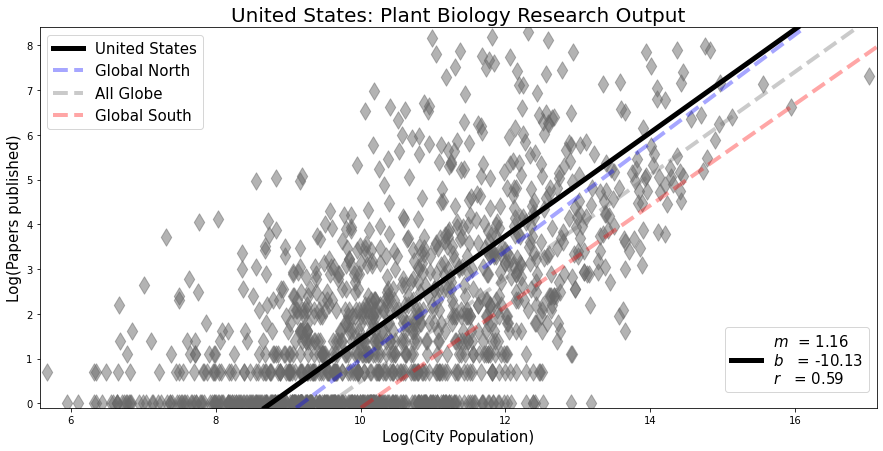

In [133]:
fs = 15
fig, ax = plt.subplots(1,1, figsize=(15,7))

ax.set_xlim((np.min(xx)-0.1, np.max(xx)+0.1))
ax.set_ylim((np.min(yy)-0.1, np.max(yy)+0.1))

legend = '$m$  = {:.2f}\n$b$   = {:.2f}\n$r$   = {:.2f}'.format(rma['slope'], rma['intercept'], rma['r'])

ax.axline(xy1=(0,rma['intercept']), slope=rma['slope'], color='k', label=country, lw=5, ls='-')
for i in range(3):
    ax.axline(xy1=(0,LRS[i]['intercept']), slope=LRS[i]['slope'], 
              color=colors[i], label=labels[i], lw=4, ls='--', alpha=0.35)

ax.scatter(xx,yy, c='dimgray', s=150, marker='d', alpha=0.5)

ax.legend(fontsize=fs);

h, l = ax.get_legend_handles_labels()
fig.legend([h[0]], [legend], fontsize=fs, fancybox=True,
           bbox_to_anchor=(0.9, 0.3));

ax.set_xlabel('Log(City Population)', fontsize=fs)
ax.set_ylabel('Log(Papers published)', fontsize=fs)
ax.set_title(country + ': Plant Biology Research Output', fontsize=fs+5)

filename = '../plots/' + country.lower().replace(' ','_') + '_population_allometry'
print(filename)
plt.savefig(filename + '.jpg', dpi=100, format='jpg', bbox_inches='tight', pil_kwargs={'optimize':True})

In [134]:
ccmask = ((data.loc[cmask, 'score'] > 3).values) | (data.loc[cmask, 'population'] > 0.75*np.mean(data.loc[cmask, 'population'])).values

In [135]:
sami_c = rma['rdp'][ccmask]
asami_c = np.abs(sami_c)
ssami_c = np.argsort(sami_c)[::-1]
sssami_c = np.argsort(ssami_c)

sami_g = LRS[1]['rdp'][cmask]
sami_g = sami_g[ccmask]
asami_g = np.abs(sami_g)
ssami_g = np.argsort(sami_g)[::-1]
sssami_g = np.argsort(ssami_g)

sami = [sami_c, sami_g]
asami = [asami_c, asami_g]
ssami = [ssami_c, ssami_g]
sssami = [sssami_c, sssami_g]

In [152]:
rlatlon = data.loc[cmask,['latitude', 'longitude']].values
rlatlon = rlatlon[ccmask]

pad1 = .1  #padding, degrees unit

poly = [df.loc[df['ISO_A2'] == iso]['geometry'].values[0]]

exts = [poly[0].bounds[0] - pad1, poly[0].bounds[2] + pad1, poly[0].bounds[1] - pad1, poly[0].bounds[3] + pad1];
exts[0] = -123; exts[1] = -66; exts[2]= 18; exts[3] = 49
#exts[2] = -35
rmask = (rlatlon[:, 0] > exts[2]) & (rlatlon[:, 0] < exts[3]) & (rlatlon[:,1] > exts[0]) & (rlatlon[:,1] < exts[1])

../plots/united_states_research_sami


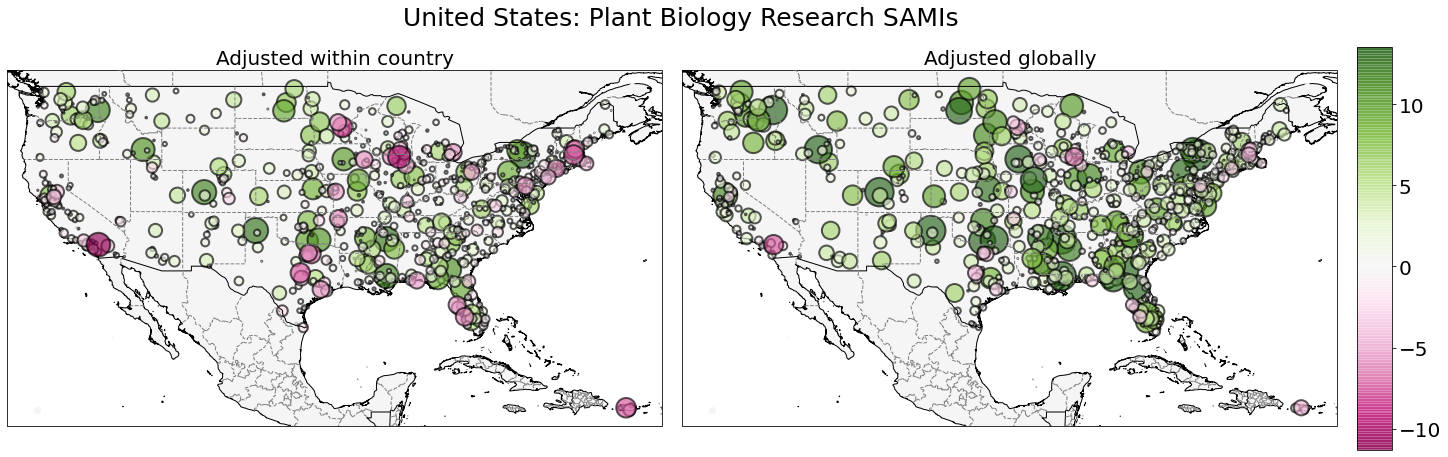

In [191]:
fs = 20
NNN = 5e1

divnorm = ccolors.TwoSlopeNorm(vcenter=0)
subtitle = ['Adjusted within country', 'Adjusted globally']

fig, axs = plt.subplots(nrows=1,ncols=2,constrained_layout=True,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(20,8), sharex=True, sharey=True)
fig.suptitle(country + ': Plant Biology Research SAMIs', fontsize=fs+5, x=0.47, y=0.92);

axs = np.atleast_1d(axs).flatten()

for i in range(len(axs)):
    axs[i].add_feature(land_10m, zorder=0, edgecolor='black', facecolor='whitesmoke')
    cs = axs[i].scatter(rlatlon[rmask,1], rlatlon[rmask,0], transform=ccrs.PlateCarree(), 
               s=NNN*asami[i][rmask], c=sami[i][rmask], marker='o', alpha=0.65, zorder=2, cmap='PiYG', norm=divnorm,
               edgecolor='k', linewidth=2);
    axs[i].scatter(exts[:2], exts[2:], transform=ccrs.PlateCarree(), facecolor='whitesmoke')

    axs[i].add_feature(cfeature.BORDERS, zorder=19, edgecolor='black', linestyle='-');
    axs[i].add_feature(states_provinces, edgecolor='gray', linestyle='--', zorder=20);
    axs[i].set_title(subtitle[i], fontsize=fs)

cbar = fig.colorbar(cs, shrink=0.7, pad=0.01, ax=axs.ravel().tolist())
cbar.ax.tick_params(labelsize=fs);

filename = '../plots/' + country.lower().replace(' ','_') + '_research_sami'
print(filename)
plt.savefig(filename + '.jpg', dpi=100, format='jpg', bbox_inches='tight', pil_kwargs={'optimize':True})

In [155]:
j = 0
cdatar = data.iloc[cmask]
cdatar = cdatar.iloc[ccmask]

In [184]:
i = 0
interest = set()
j = 0
for j in range(8):
    loc = cdatar.iloc[j,2].split(', ')[:2]
    loc = ', '.join(loc)
    interest.add((loc, sssami[i][j]))
    print(loc, np.round(sami[i][j],2), sssami[i][j], sep='\t')

print()

for j in range(6):
    idx = ssami[0][j]
    loc = cdatar.iloc[idx,2].split(', ')[:2]
    loc = ', '.join(loc)
    interest.add((loc, sssami[i][idx]))
    print(loc, np.round(sami[i][idx],2), sssami[i][idx], sep='\t')

Davis, CA	7.67	22
Gainesville, FL	9.46	11
Ithaca, NY	13.56	0
E Lansing, MI	5.95	42
Beltsville, MD	0.49	245
St Paul, MN	0.88	210
Berkeley, CA	0.35	273
Ames, IA	10.21	9

Ithaca, NY	13.56	0
Bushland, TX	12.58	1
University, MS	12.35	2
Crested Butte, CO	11.72	3
Poplarville, MS	11.71	4
Pullman, WA	11.64	5


In [185]:
counter,j = 0,0
while counter < 6:
    k = ssami[i][j]
    if cdatar.iloc[k,3] > 50:
        loc = cdatar.iloc[k,2].split(', ')[:2]
        loc = ', '.join(loc)
        interest.add((loc, sssami[i][k]))
        print(loc, np.round(sami[i][k],2), sssami[i][k], sep='\t')
        counter += 1
    j += 1

Ithaca, NY	13.56	0
University, MS	12.35	2
Crested Butte, CO	11.72	3
Poplarville, MS	11.71	4
Pullman, WA	11.64	5
Tifton, GA	10.97	6


In [186]:
counter,j = 0,-1
while counter < 6:
    k = ssami[i][j]
    if cdatar.iloc[k,8] > 1e5:
        #if cdatar.iloc[k,4] > 12:
        #    loc = cdatar.iloc[k,3].split(', ')[0]
        #else:
        loc = cdatar.iloc[k,2].split(', ')[:2]
        loc = ', '.join(loc)
        interest.add((loc, sssami[i][k]))
        print(k, cdatar.iloc[k,[2,8,6]].values, np.round(sami[i][k],2), sssami[i][k], sep='\t')
        counter += 1
    j -= 1

750	['Lakeview, CA, USA' 533058 'Lakeview']	-11.29	756
748	['Crystal Lake, IL, USA' 404190 'Crystal Lake']	-9.93	755
745	['Rockford, MN, USA' 271709 'Rockford']	-8.11	754
746	['Puerto Rico, PR, USA' 244391 'Jayuya']	-7.66	753
755	['Bolton, MA, USA' 238508 'Bolton']	-7.56	752
747	['Ft Hood, TX, USA' 238470 'Fort Hood']	-7.56	751


In [187]:
print(len(interest))
interest

20


{('Ames, IA', 9),
 ('Beltsville, MD', 245),
 ('Berkeley, CA', 273),
 ('Bolton, MA', 752),
 ('Bushland, TX', 1),
 ('Crested Butte, CO', 3),
 ('Crystal Lake, IL', 755),
 ('Davis, CA', 22),
 ('E Lansing, MI', 42),
 ('Ft Hood, TX', 751),
 ('Gainesville, FL', 11),
 ('Ithaca, NY', 0),
 ('Lakeview, CA', 756),
 ('Poplarville, MS', 4),
 ('Puerto Rico, PR', 753),
 ('Pullman, WA', 5),
 ('Rockford, MN', 754),
 ('St Paul, MN', 210),
 ('Tifton, GA', 6),
 ('University, MS', 2)}

In [188]:
ranks = pd.DataFrame(interest, columns=['location', 'rank']).sort_values(by='rank').values
ranks[:,1] += 1
ypos = (np.linspace(np.max(sami[i])-0.3, np.min(sami[i])+0.3, len(ranks)))
print(len(ranks))
ranks = np.flip(ranks, 1).astype(str)
ranks

20


array([['1', 'Ithaca, NY'],
       ['2', 'Bushland, TX'],
       ['3', 'University, MS'],
       ['4', 'Crested Butte, CO'],
       ['5', 'Poplarville, MS'],
       ['6', 'Pullman, WA'],
       ['7', 'Tifton, GA'],
       ['10', 'Ames, IA'],
       ['12', 'Gainesville, FL'],
       ['23', 'Davis, CA'],
       ['43', 'E Lansing, MI'],
       ['211', 'St Paul, MN'],
       ['246', 'Beltsville, MD'],
       ['274', 'Berkeley, CA'],
       ['752', 'Ft Hood, TX'],
       ['753', 'Bolton, MA'],
       ['754', 'Puerto Rico, PR'],
       ['755', 'Rockford, MN'],
       ['756', 'Crystal Lake, IL'],
       ['757', 'Lakeview, CA']], dtype='<U17')

In [189]:
xpos = np.linspace(2,len(sami[0])-1, len(ranks)).astype(int)
xpos

array([  2,  41,  81, 121, 160, 200, 240, 279, 319, 359, 398, 438, 478,
       517, 557, 597, 636, 676, 716, 756])

../plots/united_states_sami_ranks


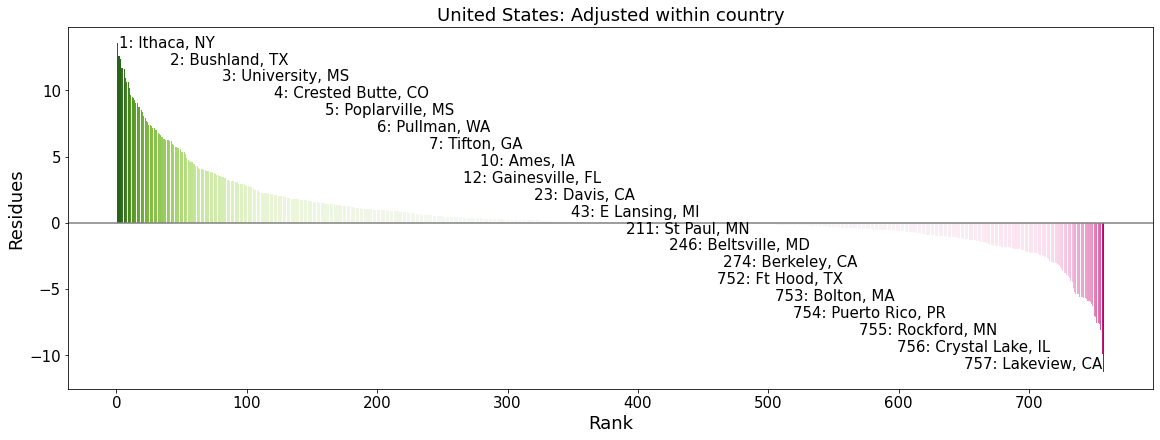

In [190]:
fs = 15
fig, axs = plt.subplots(1,1,sharex=True, sharey=True, constrained_layout=True, figsize=(16,6))
axs = np.atleast_1d(axs).flatten()
axs[0].set_ylabel('Residues', fontsize=fs+3)
for i in range(len(axs)):
    residues = sami[i][ssami[i]]
    midpoint = 1 - np.max(sami[i])/np.abs(np.max(sami[i]) - np.min(sami[i]))
    norm_sami = sami[i]-np.min(sami[i])
    norm_sami /= np.max(norm_sami)
    norm_sami -= midpoint - 0.5
    cols = mycmap(norm_sami)
    axs[i].bar(np.arange(len(sami[i]))+1, residues, color=cols[ssami[i]]);
    axs[i].set_xlabel('Rank', fontsize=fs+3)
    axs[i].axhline(y=0, c='gray')
    axs[i].tick_params(labelsize=fs)
    axs[i].set_title(country + ': ' + subtitle[i], fontsize=fs+3)

for j in range(len(ranks)):
    if residues[xpos[j]] > 0.2:
        ha = 'left'
    elif np.abs(residues[xpos[j]]) <= 0.2:
        ha = 'center'
    else:
        ha = 'right'
    axs[0].text(xpos[j], ypos[j], ': '.join(ranks[j]), fontsize=fs, ha=ha)
    
#fig.suptitle(country + ': SAMIs Ranks', fontsize=fs+5);
filename = '../plots/' + country.lower().replace(' ','_') + '_sami_ranks'
print(filename)
plt.savefig(filename + '.jpg', dpi=100, format='jpg', bbox_inches='tight', pil_kwargs={'optimize':True})

In [59]:
ypos

array([-2.92111684, -2.43154166, -1.94196648, -1.45239129, -0.96281611,
       -0.47324093,  0.01633426,  0.50590944,  0.99548462,  1.48505981,
        1.97463499,  2.46421017,  2.95378535,  3.44336054,  3.93293572,
        4.4225109 ,  4.91208609,  5.40166127,  5.89123645])